In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12,5)})
%load_ext autoreload
%autoreload 2

In [2]:
import re
from fuzzywuzzy import process
import pprint

In [3]:
df = pd.read_parquet("proceedings.parquet")

In [4]:
df["volume"] = df["conference"].apply(lambda x: x.split(":")[0].split(" ")[1])

In [5]:
df['year'] = df['conference'].apply(lambda x: re.search(r'(19|20)\d{2}', str(x)).group(0) if re.search(r'(19|20)\d{2}', str(x)) else None)

In [6]:
df['year'].value_counts()

year
2022    3229
2023    3106
2021    2834
2020    2407
2019    1840
2018    1255
2017     948
2016     708
2014     574
2015     545
2013     438
2012     284
2011     221
2010     201
2009     111
2007      86
2008      41
2006       5
Name: count, dtype: int64

In [7]:
df["conference_main"] = df["conference"].apply(lambda x: x.split(":")[1].split(',')[0])

In [8]:
df.loc[df['year'].isna(), 'conference'].unique()

array(['Volume 117: Algorithmic Learning Theory, , San Diego, California, USA',
       'Volume 201: International Conference on Algorithmic Learning Theory, , Singapore',
       'Volume 209: Conference on Health, Inference, and Learning, , 415 Main Street, Cambridge, MA USA 02142'],
      dtype=object)

In [9]:
df.loc[df['volume'] == '117', 'year'] = '2020'

In [10]:
df.loc[df['volume'] == '201', 'year'] = '2023'

In [11]:
df.loc[df['volume'] == '209', 'year'] = '2023'

In [12]:
def get_best_match(name, choices):
    return process.extractOne(name, choices)

In [13]:
df['conference_main'] = df['conference_main'].apply(lambda c: c[1:])

In [14]:
# df['conference_main'].apply(remove_prefix)

In [15]:
import networkx as nx

In [16]:
unique_conferences = set(df['conference_main'])

name_mapping = {}
names_graph = nx.Graph()
names_graph.add_nodes_from(unique_conferences)

for conference in unique_conferences:
    match, score = get_best_match(conference, unique_conferences - {conference})
    if score >= 90:
        names_graph.add_edge(conference, match)
        # name_mapping[conference] = match

In [17]:
for c in nx.connected_components(names_graph):
    if len(c) > 1:
        target_name = min(c, key=len)
        for conference in c:
            name_mapping[conference] = target_name

In [18]:
for c1, c2 in name_mapping.items():
    if 'learning theory' in c1.lower():
        print(f'{c1}\n -> {c2}\n')

Conference on Learning Theory
 -> Conference on Learning Theory

Conference On Learning Theory
 -> Conference on Learning Theory

Proceedings of the 24th Annual Conference on Learning Theory
 -> Conference on Learning Theory

The Thirty Sixth Annual Conference on Learning Theory
 -> Conference on Learning Theory

International Conference on Algorithmic Learning Theory
 -> Algorithmic Learning Theory

Algorithmic Learning Theory
 -> Algorithmic Learning Theory



In [19]:
# def remove_prefix(name):
#     pattern = r'.*?(\b(?!(with|health)\b)\w*th)\b.*?\s'
#     name = re.sub(pattern, '', name).strip()

#     return name

In [20]:
def clean_conference_name(name):
    pattern_prefix = r'.*?(\b(?!(with|health)\b)\w*th)\b.*?\s'
    name = re.sub(pattern_prefix, '', name).strip()
    name = re.sub(r'[0-9\']', '', name)

    return name

In [21]:
df['conference_main'] = df['conference_main'].map(name_mapping).fillna(df['conference_main']).apply(clean_conference_name)

In [22]:
[c for c in df['conference_main'].unique() if 'learning theory' in c.lower()]

['Conference on Learning Theory', 'Algorithmic Learning Theory']

In [23]:
(df[['conference_main', 'volume']].drop_duplicates()['conference_main'].value_counts() > 1).value_counts(normalize=True)

count
False    0.619048
True     0.380952
Name: proportion, dtype: float64

In [24]:
df.loc[df['year'].apply(int) > 2018, 'conference_main'].value_counts(normalize=False).tail(10)

conference_main
The  ACM SIGKDD Workshop on Causal Discovery                                                                                            8
Proceedings on "I Cant Believe Its Not Better!  - Understanding Deep Learning Through Empirical Falsification" at NeurIPS  Workshops    7
nd Workshop on Online Recommender Systems and User Modeling                                                                             7
European Conference on Machine Learning and Principles and Practice of Knowledge Discovery in Databases                                 7
Causal Analysis Workshop Series                                                                                                         6
Artificial Intelligence Diversity                                                                                                       5
Workshop on Artificial Intelligence in Affective Computing                                                                              5
HEAR              

In [25]:
df[['title', 'authors', 'conference_main', 'year', 'volume']]

,title,authors,conference_main,year,volume
0,Gaussian Process Approximations of Stochastic ...,"Cedric Archambeau, Dan Cornford, Manfred Opper...",Gaussian Processes in Practice,2006,1
1,Multi-class Semi-supervised Learning with the ...,"Simon Rogers, Mark Girolami",Gaussian Processes in Practice,2006,1
2,Learning RoboCup-Keepaway with Kernels,"Tobias Jung, Daniel Polani",Gaussian Processes in Practice,2006,1
3,Salient Point and Scale Detection by Minimum L...,"Kim S. Pedersen, Marco Loog, Pieter Dorst",Gaussian Processes in Practice,2006,1
4,Sparse Log Gaussian Processes via MCMC for Spa...,"Jarno Vanhatalo, Aki Vehtari",Gaussian Processes in Practice,2006,1
...,...,...,...,...,...
18950,Fisher-Rao and pullback Hilbert cone distances...,Frank Nielsen,Topological,2023,221
18951,On Explicit Curvature Regularization in Deep G...,"Yonghyeon Lee, Frank C. Park",Topological,2023,221
18952,MASIL: Towards Maximum Separable Class Represe...,Anant Khandelwal,Topological,2023,221
18953,Topological Feature Selection,"Antonio Briola, Tomaso Aste",Topological,2023,221


In [26]:
df["authors_list"] = df["authors"].apply(lambda auths: auths.split(",\xa0"))

In [27]:
from collections import Counter

In [28]:
authors_counter = Counter([a for a_list in df["authors_list"].to_list() for a in a_list])

In [29]:
pd.DataFrame(authors_counter.most_common(10))

,0,1
0,Sergey Levine,97
1,Masashi Sugiyama,90
2,Quanquan Gu,79
3,Andreas Krause,79
4,Bernhard Schölkopf,76
5,Yoshua Bengio,66
6,Csaba Szepesvari,63
7,Pieter Abbeel,62
8,Shie Mannor,61
9,Michal Valko,60


In [30]:
pd.Series(" ".join(df["title"].values.flatten()).lower().split(" ")).value_counts().head(10)

for         6419
learning    4933
of          3809
with        3511
and         3349
in          2717
a           2228
the         2154
on          1342
neural      1243
Name: count, dtype: int64

In [31]:
from nltk.corpus import stopwords 
from nltk.tokenize import wordpunct_tokenize

In [32]:
all_titles = " ".join(df["title"].values.flatten()).lower().split(" ")

In [33]:
all_titles_filtered = [w for w in all_titles if w not in stopwords.words("english")]

In [34]:
pd.Series(all_titles_filtered).value_counts(normalize=False).head(20)

learning         4933
neural           1243
networks         1197
models           1179
via              1153
data              954
deep              951
optimization      914
reinforcement     848
using             825
stochastic        700
bayesian          695
model             626
linear            615
inference         598
efficient         579
online            575
estimation        567
robust            532
graph             526
Name: count, dtype: int64

In [35]:
is_it_causal = df["title"].apply(lambda title: 'caus' in title.lower())
most_published_causal = df.loc[is_it_causal, 'authors_list'].explode().value_counts().head(15)

In [36]:
most_published_causal

authors_list
Bernhard Schölkopf    24
Dominik Janzing       22
Kun Zhang             13
Shohei Shimizu        10
Elias Bareinboim      10
Caroline Uhler        10
Peter Spirtes          9
Judea Pearl            7
Negar Kiyavash         7
Chandler Squires       6
Ricardo Silva          6
Tom Claassen           6
Limor Gultchin         5
Matt Kusner            5
Patrick Bloebaum       5
Name: count, dtype: int64

Text(0.5, 1.0, 'Causal')

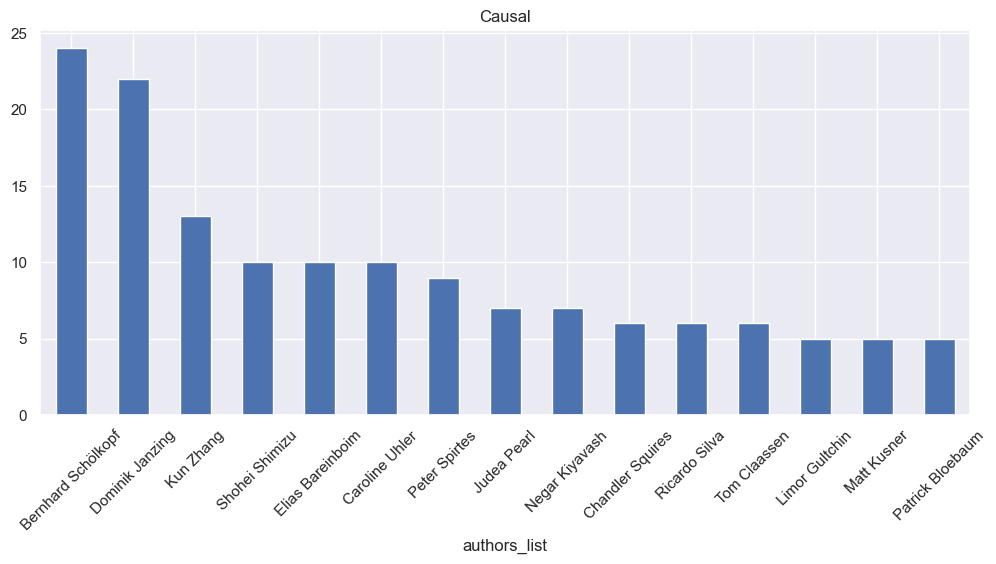

In [37]:
most_published_causal.plot.bar()
plt.xticks(rotation=45)
plt.title("Causal")

In [38]:
is_it_privacy = df["title"].apply(lambda title: 'priva' in title.lower())
most_published_privacy = df.loc[is_it_privacy, 'authors_list'].explode().value_counts().head(15)

Text(0.5, 1.0, 'Privacy')

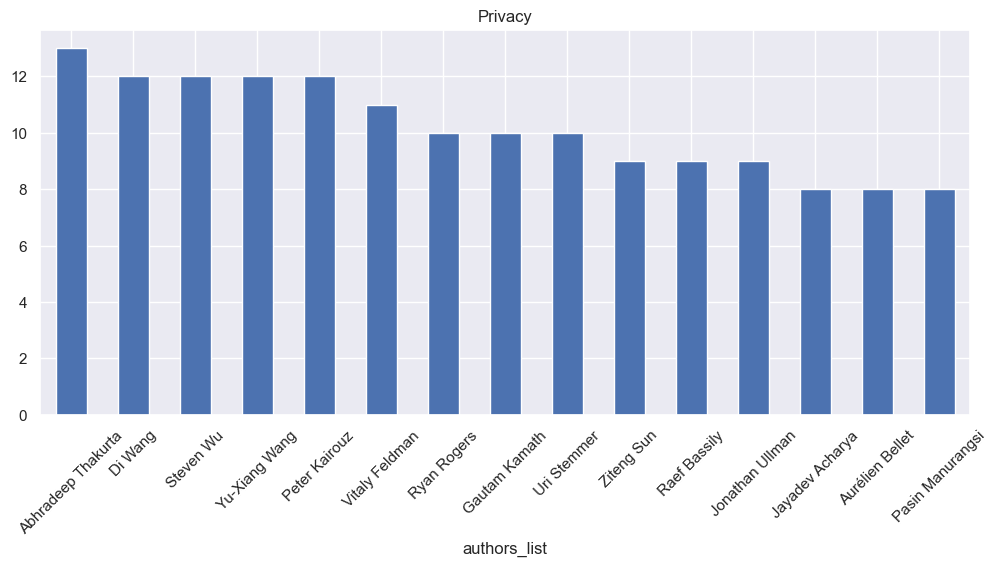

In [39]:
most_published_privacy.plot.bar()
plt.xticks(rotation=45)
plt.title("Privacy")

In [40]:
df['conference_main'].value_counts().head(10)

conference_main
International Conference on Machine Learning    8361
Artificial Intelligence and Statistics          3653
Conference on Learning Theory                   1246
Uncertainty in Artificial Intelligence           938
Conference on Robot Learning                     762
Asian Conference on Machine Learning             633
Learning for Dynamics and Control                410
Machine Learning for Health                      359
Algorithmic Learning Theory                      284
Medical Imaging with Deep Learning               273
Name: count, dtype: int64

In [45]:
is_it_active = df["title"].apply(lambda title: 'activ' in title.lower())
most_published_active = df.loc[is_it_active, 'authors_list'].explode().value_counts().head(15)

Text(0.5, 1.0, 'Active')

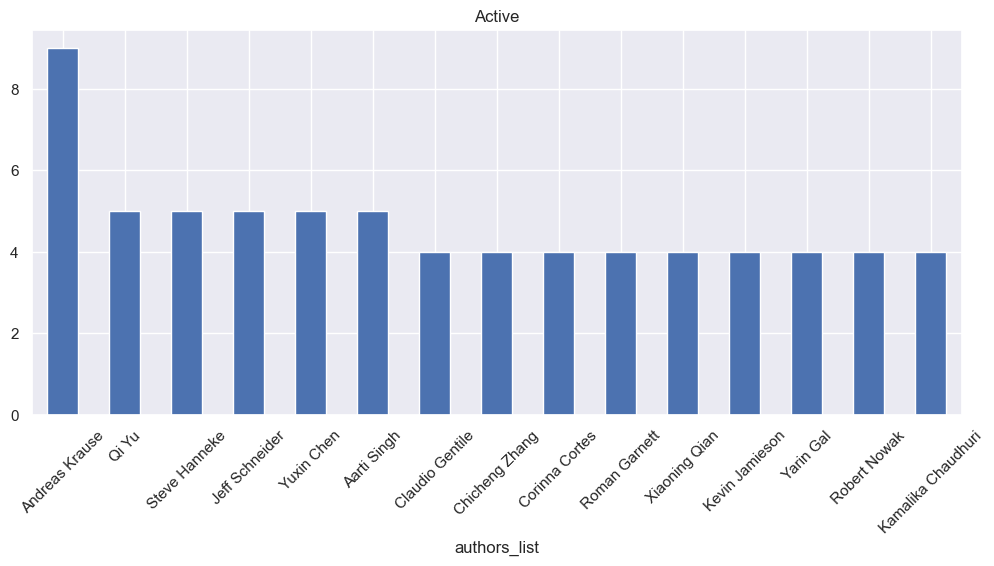

In [46]:
most_published_active.plot.bar()
plt.xticks(rotation=45)
plt.title("Active")

In [49]:
is_it_reinforcement = df["title"].apply(lambda title: 'reinforcement' in title.lower())
most_published_reinforcement = df.loc[is_it_reinforcement, 'authors_list'].explode().value_counts().head(15)

Text(0.5, 1.0, 'Reinforcement')

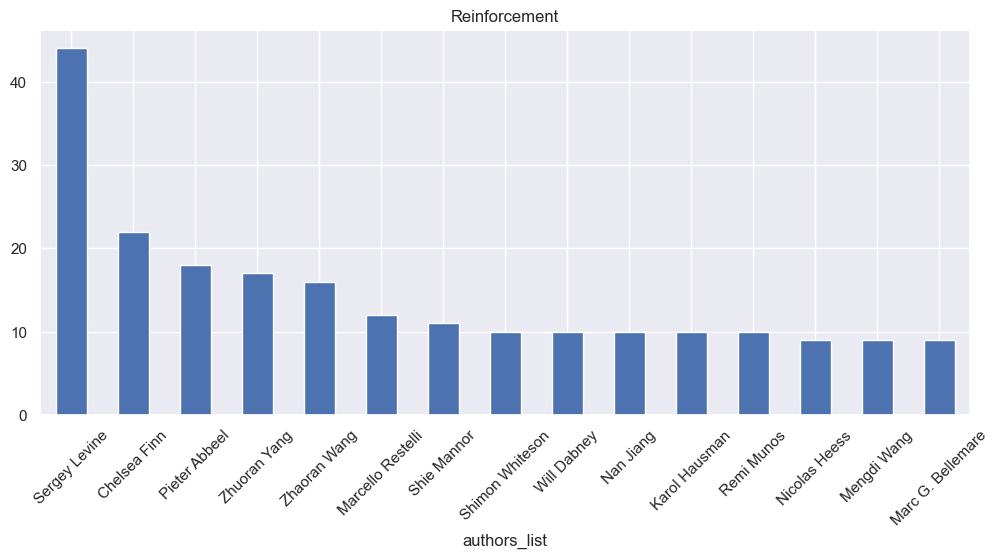

In [50]:
most_published_reinforcement.plot.bar()
plt.xticks(rotation=45)
plt.title("Reinforcement")